In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

In [2]:
[{'clf_knn__n_neighbors': list(range(1, 10)),
                   'clf_knn__p': [1, 2],
                   'clf_knn__leaf_size': np.arange(10,51,10)}]

[{'clf_knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9],
  'clf_knn__p': [1, 2],
  'clf_knn__leaf_size': array([10, 20, 30, 40, 50])}]

In [37]:
df.index = range(len(df))
df.tail()    

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
8142,SE,3729.0,7,3.0,4.0,5.0,3.0,6.0,6.0,2.0,1.0,18.0,2.0
8143,SE,3732.0,7,5.0,6.0,4.0,4.0,10.0,6.0,3.0,1.0,15.0,2.0
8144,SE,3743.0,7,4.0,5.0,7.0,6.0,8.0,6.0,3.0,1.0,44.0,2.0
8145,SE,3744.0,7,5.0,8.0,8.0,6.0,9.0,7.0,3.0,1.0,15.0,2.0
8146,SE,3746.0,7,2.0,6.0,7.0,5.0,7.0,7.0,4.0,2.0,15.0,2.0


In [38]:
# transform to ordinal based upon percentiles, n is ordinal range
def ord_by_percentile(srs,n):
    pce = np.percentile(srs, [(i * 100 / n) for i in range(1, n + 1)])
    ret = pd.Series(np.zeros(srs.shape,  dtype=int)) 
    for i in range(len(pce)):
        ret = ret.where(srs < pce[i], other = i + 1)
    return ret

In [39]:
def transform_zscore(srs): 
    return srs.apply( lambda x: (x-srs.mean()) / srs.std())

In [40]:
# transform target to 0 and 1.
y = df['partner'] - 1

In [41]:
dfx = df.drop([lbl for lbl in df.columns if lbl != 'agea'], axis=1)

In [42]:
#added feature dfx.agea transformed by zscore 
dfx['age_z'] = transform_zscore(dfx.agea)
#added feature dfx.agea to ordinal by quintiles 
dfx['age_ord'] = ord_by_percentile(dfx.agea, 5)

In [43]:
dfx.tail()

,agea,age_z,age_ord
8142,18.0,-1.597552,0
8143,15.0,-1.761335,0
8144,44.0,-0.178097,2
8145,15.0,-1.761335,0
8146,15.0,-1.761335,0


In [106]:
# add n PCA features

n=5
pca = df.drop(['agea', 'cntry', 'idno', 'partner' ], axis=1).values 
pca = StandardScaler().fit_transform(pca)
pca = PCA(n_components=n).fit_transform(pca)
dfp = pd.DataFrame(data = pca, columns = ['pca' + str(i) for i in range(1,n+1)])

#### initial results
Training set accuracy:
- Percent Type I errors: 0.04650845608292417
- Percent Type II errors: 0.17607746863066012

Test set accuracy:
- Percent Type I errors: 0.06257668711656442
- Percent Type II errors: 0.18527607361963191

In [107]:
# X with all features
X = pd.concat([dfx, dfp, pd.get_dummies(df['cntry'])], axis=1)
X1 = X.drop(['age_z', 'age_ord', 'CH', 'CZ', 'DE','ES', 'NO', 'SE'], axis=1)
X2 = X.drop(['agea', 'age_ord', 'CH', 'CZ', 'DE','ES', 'NO', 'SE'], axis=1)
X3 = X.drop(['agea', 'age_ord'], axis=1)
X4 = X.drop(['CH', 'CZ', 'DE','ES', 'NO', 'SE'], axis=1)

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

In [108]:
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.1)
params = {'n_estimators': 500,'max_depth': 2, 'loss': 'deviance'}
clf = ensemble.GradientBoostingClassifier(**params)

In [109]:
prm0 = {'n_estimators': 500,'max_depth': 2,'loss': 'deviance'}
prm1 = {'n_estimators': 500,'max_depth': 2,'loss': 'exponential'}
prm2 = {'n_estimators': 750,'max_depth': 2,'loss': 'deviance'}
prm3 = {'n_estimators': 100,'max_depth': 2,'loss': 'deviance', 'verbose':1}
prm4 = {'n_estimators': 500,'max_depth': 3,'loss': 'deviance', 'verbose':1}
prm5 = {'n_estimators': 500,'max_depth': 4,'loss': 'deviance'}
prm6 = {'n_estimators': 750,'max_depth': 3,'loss': 'exponential'}

In [110]:
clf.set_params(**prm0).fit(X_trn,  y_trn)
round(clf.score(X_tst, y_tst), 4)

0.7632

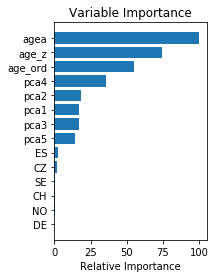

In [111]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
X1 = 

In [ ]:
table_train.sum().sum()

In [ ]:
table_train

In [ ]:
table_train.columns.name = 'target'
table_train.columns = ['false', 'True', 'totals']

In [ ]:
# returns (type I error %, type II error %)
def accuracy_tab(y,prd):
    tab = pd.crosstab(y, prd)
    return (tab.loc[0.0,1.0]  / tab.sum().sum(), tab.loc[1.0,0.0]  / tab.sum().sum())


In [ ]:
table_train.index = ['false', 'true', 'totals' ]

In [ ]:
table_train.index

In [ ]:
table_train.columns

In [ ]:
sns.set_style("whitegrid")
g = sns.PairGrid(X.iloc[:,:5], diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot, lw=3)
plt.show()

In [ ]:
sns.set_style("whitegrid")
g = sns.PairGrid(X.iloc[:,5:10], diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot, lw=3)
plt.show()

In [ ]:
A = df[df.partner == 1].sample(n=5000, replace=True)
B = df[df.partner == 2].sample(n=5000, replace=True)
AB = pd.concat([A,B])

In [ ]:
X.agea.describe()

In [ ]:
ax = sns.countplot(x="partner", hue="cntry", data=AB)